In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [14]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env._max_episode_steps = 200

In [120]:
from torch import nn
import torch.nn.functional as F
from gymnasium import spaces
import numpy as np
from tqdm import tqdm

class TDLambda(nn.Module):
    def __init__(self, env, lam: float = 0.9, discount: float = 0.95, alpha: float = 0.15, action_size = 3, observation_size = 2):
        self.lam = lam
        self.discount = discount
        self.alpha = alpha

        # environment specific vars
        self.action_space = spaces.Discrete(action_size)
        self.action_size = action_size
        self.observation_size = observation_size
        
        self.env = env

        # metrics 
        self.actions = []
        self.rewards = []
        self.observations = []

        self.E = {}
        self.V = {}

        self.policy = {}

    def init_policy(self):
        for i in np.linspace(-1.2, 0.6, 37, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 29, dtype=np.float32):
                self.policy[(i, j)] = [0, 0, 0]

    def train(self, total_steps: int = 5000):
        self.init_policy()
        self.initialize_values_and_traces()
        obs = self.env.reset()
        obs = obs[0]
        self.observations.append(obs)
        self.rewards.append(0)

        action = None
        dones = 0

        for step in tqdm(range(total_steps), desc="training td-lambda"):
            prevobs = obs
            action = self.choose_action(prevobs)
            obs, rew, done, trunc, info = self.env.step(action)
            td = rew + self.discount * self.value(obs) - self.value(prevobs)
            self.eligibility_trace(prevobs)

            for s in self.V.keys():
                self.V[s] += self.alpha * td * self.E[s]
                self.E[s] *= self.discount * self.lam

            # print(self.rewards[-1] + self.discount * self.value(obs) - self.value(prevobs))
            self.policy[(np.float32(np.round(prevobs[0]*20)/20), np.float32(np.round(prevobs[1]*2, 2)/2))][action] += 0.01 * (self.rewards[-1] + self.discount * self.value(obs) - self.value(prevobs))

            self.observations.append(obs)
            self.rewards.append(rew)
            self.actions.append(action)

            if done or trunc:
                dones+=1
                self.reset_traces()
                obs = self.env.reset()
                obs = obs[0]
                self.rewards.append(0)
                self.observations.append(obs)
            
        print(dones)


    def eval(self, episodes: int = 5):
        obs = self.env.reset()[0]
        rewards = []
        actions = []
        observations = []
        observations.append(obs)
        cur_reward = 0

        for e in range(episodes):
            while True:
                # action_list = list(map(np.mean, self.policy[(np.round(obs[0], 1), np.round(obs[1], 2))]))
                action_list = self.policy[(np.round(obs[0], 1), np.round(obs[1], 2))]
                action = np.argmax(action_list)
                actions.append(action)
                obs, rew, done, trunc, info = self.env.step(action)
                observations.append(obs)
                cur_reward+=rew
                if done or trunc:
                    rewards.append(cur_reward)
                    cur_reward = 0
                    obs = env.reset()[0]
                    break

        return rewards, actions, observations


    def initialize_values_and_traces(self):
        for i in np.linspace(-1.2, 0.6, 37, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 29, dtype=np.float32):
                if i>=0.5: 
                    self.V[(i, j)] = 1
                    self.E[(i, j)] = 0
                    continue
                self.V[(i, j)] = 0
                self.E[(i, j)] = 0
    

    def reset_traces(self):
        for i in np.linspace(-1.2, 0.6, 37, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 29, dtype=np.float32):
                if i>=0.5: 
                    self.E[(i, j)] = 0
                    continue
                self.E[(i, j)] = 0


    def eligibility_trace(self, state):
        pos = np.round(state[0]*20)/20
        vel = np.round(state[1]*20, 1)/20
        value = (np.float32(pos), np.float32(vel))
        self.E[value] += 1
        return self.E[value]


    def value(self, state):
        pos = np.round(state[0]*20)/20
        vel = np.round(state[1]*20, 1)/20
        value = (np.float32(pos), np.float32(vel))
        return self.V[value]


    def choose_action(self, prevobs):
        # return np.random.choice(3, 1)[0]
        return np.argmax(self.policy[(np.float32(np.round(prevobs[0]*20)/20), np.float32(np.round(prevobs[1]*2, 2)/2))])
        # return 2

In [121]:
model = TDLambda(env)
model.train(5000)

training td-lambda: 100%|██████████| 5000/5000 [00:07<00:00, 649.48it/s]

25


In [122]:
rewards, actions, observations = model.eval(20)

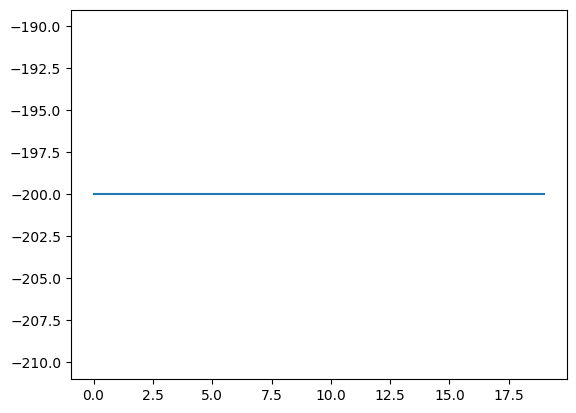

In [123]:
plt.plot(rewards)

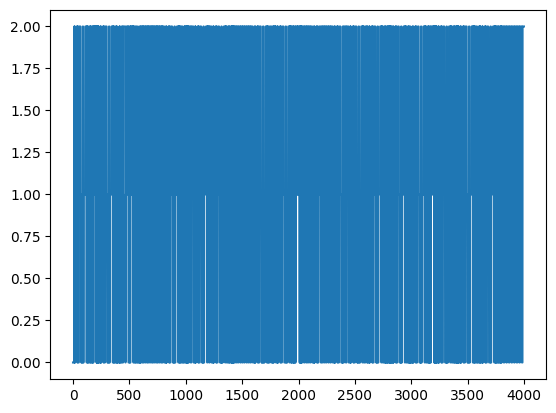

In [115]:

plt.plot(actions)

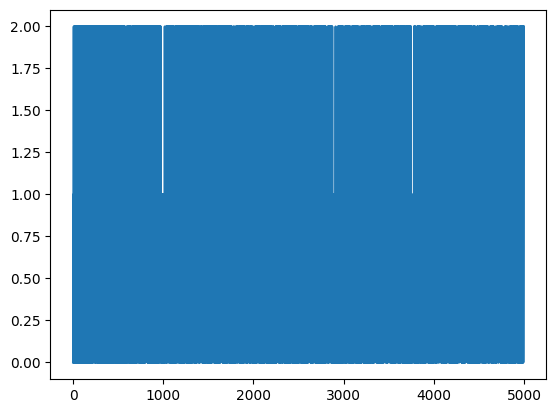

In [116]:
plt.plot(model.actions)

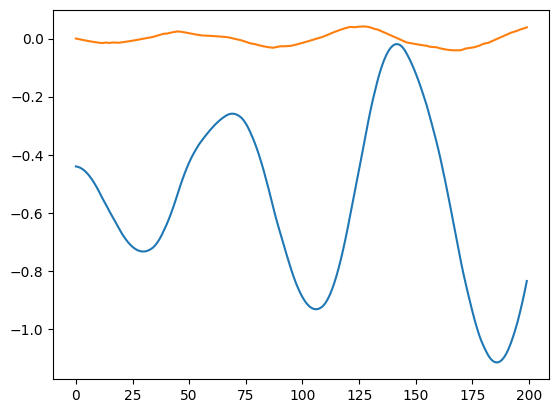

In [118]:
plt.plot(observations[0:200])

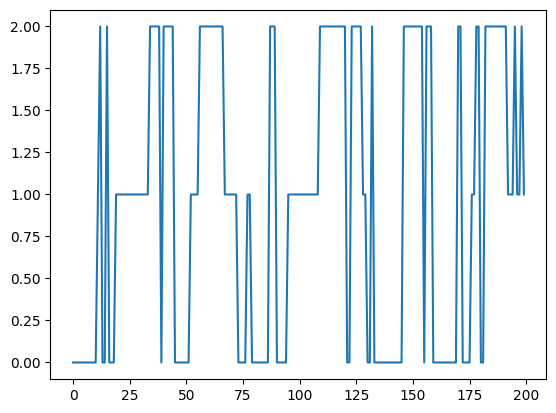

In [119]:
plt.plot(actions[0:200])